In [1]:
import pandas as pd
import numpy as np

# 날짜
import datetime as dt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 딥러닝
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

pd.options.display.float_format = '{:.5f}'.format

In [2]:
# 데이터 로드
df = pd.read_csv("./data/bus_final.csv")

In [3]:
# 데이터 프레임 상단 5개 조회
df.head(5)

,bstopId,routeNo,routeId,bstopNm,busId,LATEST_STOP_NAME,Bus_Num_Plate,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT
0,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2757,2022-02-16 15:05:22
1,164000346,M6724,165000381,동춘역,7331707,부천IC출입(미정차),인천73아1707,1,1649,2022-02-16 15:05:24
2,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2633,2022-02-16 15:06:01
3,164000346,M6724,165000381,동춘역,7331707,부천IC출입(미정차),인천73아1707,1,1616,2022-02-16 15:06:03
4,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2648,2022-02-16 15:06:29


In [4]:
# 인덱스 유니크값 수 = 전체 데이터 수
df.index.nunique()

257290

# 데이터 전처리

In [5]:
# 고유값이 1인 변수 제거 > 분석에 무의미
# bstopNm 제거 > bstopId 와 의미 중복
df.drop(columns=['routeNo', 'routeId', 'bstopNm', 'LATEST_STOP_NAME', 'Bus_Num_Plate'], inplace=True)

In [6]:
# stopId 변수 라벨링
bstopId_list = df.bstopId.unique().tolist()
df.insert(1,'bstopId_rabel',df.bstopId.map(lambda x: bstopId_list.index(x)))

# stopId 변수 라벨링
busId_list = df.busId.unique().tolist()
df.insert(3,'busId_rabel',df.busId.map(lambda x: busId_list.index(x)))

df.drop(columns=['bstopId', 'busId'], inplace=True)

In [7]:
df.head(5)

,bstopId_rabel,busId_rabel,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT
0,0,0,5,2757,2022-02-16 15:05:22
1,1,1,1,1649,2022-02-16 15:05:24
2,0,0,5,2633,2022-02-16 15:06:01
3,1,1,1,1616,2022-02-16 15:06:03
4,0,0,5,2648,2022-02-16 15:06:29


In [10]:
print(bstopId_list)
print(busId_list)

[113000424, 164000346, 113000412, 164000070]
[7331704, 7331707, 7331703, 7331702, 7331701, 7331706, 7331708, 7331705, 7331348]


In [11]:
# 데이터 ThisDT 변수 datatime 타입으로 변환
df['ThisDT'] =  pd.to_datetime(df['ThisDT'])

In [12]:
# 날짜 변수 생성
# df['year'] = df['ThisDT'].dt.year
df['month'] = df['ThisDT'].dt.month
df['day'] = df['ThisDT'].dt.day
df['hour'] = df['ThisDT'].dt.hour
df['minute'] = df['ThisDT'].dt.minute
df['second'] = df['ThisDT'].dt.second
# 요일 생성
# df['weekno'] = df['ThisDT'].dt.weekday
# 평일 주말 구분
# df['weekday'] = 0
# 평일은 0
# cond = (df['weekno'] < 5)
# df.loc[cond, 'weekday'] = 0
# 주말은 1
# cond = (df['weekno'] >= 5)
# df.loc[cond, 'weekday'] = 0

# df.drop(columns = ['weekno'], inplace=True)

In [13]:
# 문자형 컬럼 원핫인코딩
# df = pd.get_dummies(df, columns = ['LATEST_STOP_NAME', 'Bus_Num_Plate'])

In [14]:
df.head(5)

,bstopId_rabel,busId_rabel,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT,month,day,hour,minute,second
0,0,0,5,2757,2022-02-16 15:05:22,2,16,15,5,22
1,1,1,1,1649,2022-02-16 15:05:24,2,16,15,5,24
2,0,0,5,2633,2022-02-16 15:06:01,2,16,15,6,1
3,1,1,1,1616,2022-02-16 15:06:03,2,16,15,6,3
4,0,0,5,2648,2022-02-16 15:06:29,2,16,15,6,29


# 스케일링

In [15]:
# 최대 최소
print("최대: ", df.ARRIVALESTIMATETIME.max())
print("최소: ", df.ARRIVALESTIMATETIME.min())

최대:  5863
최소:  18


In [16]:
# y = scaled_y * (5863-18) + 18

In [17]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['ARRIVALESTIMATETIME']

# scaler.fit(df_train_y)

# df_train_x = scaler.transform(df_train_x)
# df_test_x = scaler.transform(df_test_x)

# df_train_y = scaler.transform(df_train_y)
# df_test_y = scaler.transform(df_test_y)
# X_origin = minmax_scaler.inverse_transform(X_train_scaled)



df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

concat_df = df.copy()
concat_df.drop(columns=scale_cols, inplace=True)

df = pd.concat([concat_df, df_scaled], axis=1)

In [18]:
# 학습과 테스트 데이터 분리
# 22일 전 후로 생성
df_train = df.query('ThisDT <= "2022-03-20"').copy()
df_test = df.query('ThisDT > "2022-03-20"').copy()

In [19]:
# datetime 날짜 제거 > 모델 학습에 datetime 형식 지원 안 함
df_train.drop(columns = ['ThisDT'], inplace=True)
df_test.drop(columns = ['ThisDT'], inplace=True)
# df_test = df_test.set_index('ThisDT')
# df_train = df_train.set_index('ThisDT')

In [20]:
# x, y 분리
df_train_y = df_train.loc[:,'ARRIVALESTIMATETIME']
df_train_x = df_train.drop('ARRIVALESTIMATETIME', axis=1)
df_test_y = df_test.loc[:,'ARRIVALESTIMATETIME']
df_test_x = df_test.drop('ARRIVALESTIMATETIME', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_test.loc[:, ['ARRIVALESTIMATETIME']]


In [21]:
#3차원 배열로 변환
train_x = np.array(df_train_x).reshape(df_train_x.shape[0], df_train_x.shape[1], 1)
test_x = np.array(df_test_x).reshape(df_test_x.shape[0], df_test_x.shape[1], 1)

In [22]:
test_x.shape

(135975, 8, 1)

# 모델 학습

In [23]:
#GPU 사용 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [25]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



Epoch 1/100
10919/10919 [==============================] - 47s 4ms/step - loss: 0.0174 - mae: 0.1030 - val_loss: 0.0057 - val_mae: 0.0598
Epoch 2/100
10919/10919 [==============================] - 43s 4ms/step - loss: 0.0076 - mae: 0.0671 - val_loss: 0.0060 - val_mae: 0.0600
Epoch 3/100
10919/10919 [==============================] - 43s 4ms/step - loss: 0.0069 - mae: 0.0628 - val_loss: 0.0056 - val_mae: 0.0573
Epoch 4/100
10919/10919 [==============================] - 43s 4ms/step - loss: 0.0065 - mae: 0.0609 - val_loss: 0.0052 - val_mae: 0.0545
Epoch 5/100
10919/10919 [==============================] - 44s 4ms/step - loss: 0.0063 - mae: 0.0595 - val_loss: 0.0048 - val_mae: 0.0513
Epoch 6/100
10919/10919 [==============================] - 44s 4ms/step - loss: 0.0062 - mae: 0.0589 - val_loss: 0.0047 - val_mae: 0.0506
Epoch 7/100
10919/10919 [==============================] - 44s 4ms/step - loss: 0.0060 - mae: 0.0582 - val_loss: 0.0045 - val_mae: 0.0494
Epoch 8/100
10919/10919 [=========

<AxesSubplot:>

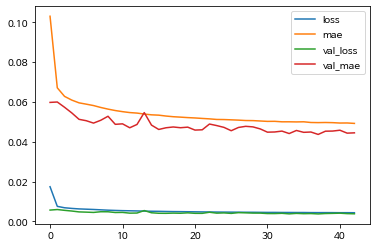

In [26]:
# input shape에 전처리된 train_x의 형태를 넣는다
# 20%로 Drop-out 했다

#activation='relu'
model = keras.Sequential()
model.add(keras.layers.LSTM(units=16,input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.Dense(units=4))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

callbacks = [
# `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
# `./logs` 디렉토리에 텐서보드 로그를 기록니다.
# tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

plot_losses = PlotLosses() # ADD

# 10개의 batch로 100번 epoch 함
history = model.fit(train_x, df_train_y, validation_split=0.1, batch_size=10, epochs=100, callbacks=[callbacks])

pd.DataFrame.from_dict(history.history).plot()

In [27]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = model.predict(test_x)

# r_sq = model.score(df_test_x, df_test_y)
mse = mean_squared_error(df_test_y, predictions)
rmse = np.sqrt(mse)
r2_ = r2_score(df_test_y, predictions)


print('R2 score(결정계수) = {:.3f}'.format(r2_))
# print('explained_variance_score(설명분산점수) : {0:.3f}'.format(explained_variance_score(predictions,df_test_y)))
print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))

R2 score(결정계수) = 0.809
MSE : 0.006 , RMSE : 0.078


In [28]:
predictions.shape

(135975, 1)

In [38]:
df_for_test = df_train_x[df_train_x.index == 9]
df_for_test

# df_tf = np.array(df_for_test).reshape(df_for_test.shape[0], df_for_test.shape[1], 1)

,bstopId_rabel,busId_rabel,Rest_Stop_Count,month,day,hour,minute,second
9,1,1,1,2,16,15,7,29


In [39]:
predictions = model.predict(df_for_test)
predictions

array([[0.225676]], dtype=float32)

# 모델 저장

In [41]:
model.save('./saved_model/model')

INFO:tensorflow:Assets written to: ./saved_model/model\assets


INFO:tensorflow:Assets written to: ./saved_model/model\assets


In [42]:
loaded = tf.saved_model.load("./saved_model/model")
print(list(loaded.signatures.keys()))

['serving_default']


# 모델 저장2

# Placeholder

In [49]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# I = tf.placeholder(tf.float32, [None, 35, 1])
# W = tf.placeholder(tf.float32, [1, 1])

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())


# export_dir_path = "./saved_model/my_model_2"

# builder = tf.saved_model.builder.SavedModelBuilder(export_dir_path)

# signature = tf.saved_model.signature_def_utils.build_signature_def(
# #     inputs={
# #         "in1": tf.saved_model.utils.build_tensor_info(self.X)
# #     },
# #     outputs={
# #         "out1": tf.saved_model.utils.build_tensor_info(self.output)
# #     },
#     method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
# )
# builder.add_meta_graph_and_variables(
#     sess,
#     tags=[tf.saved_model.tag_constants.SERVING],
#     signature_def_map={"Bus": signature},
#     assets_collection=None,
#     legacy_init_op=None,
#     clear_devices=None,
#     main_op=None)
# builder.save()

# sess.close()

# 결과 시각화

In [53]:
# bstopId
# 113000424 합정역 > 서울역 방면
# 164000346 동춘역 > 연세대(인천) 방면
# 113000412 합정역 > 연세대(인천) 방면
# 164000070 동춘역 > 서울역 방면

print("bstopId 라벨\n")
for i in range(len(bstopId_list)):
    print('{}은 {}'.format(i, bstopId_list[i]))

bstopId 라벨

0은 113000424
1은 164000346
2은 113000412
3은 164000070


In [54]:
print("busId 라벨\n")
for i in range(len(busId_list)):
    print('{}은 {}'.format(i, busId_list[i]))

busId 라벨

0은 7331704
1은 7331707
2은 7331703
3은 7331702
4은 7331701
5은 7331706
6은 7331708
7은 7331705
8은 7331348


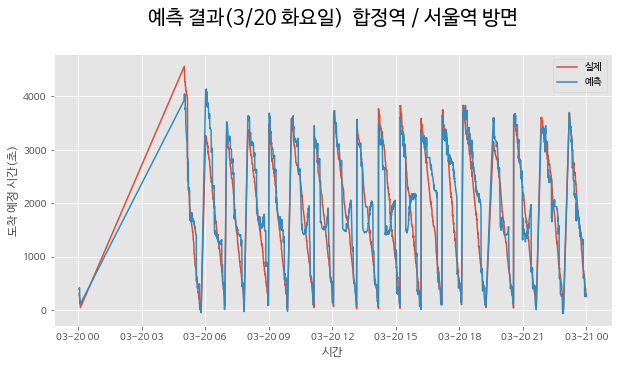

In [68]:
df1 = df_test_x[(df_test_x['bstopId_rabel']==0) & (df_test_x['month'] == 3) & (df_test_x['day'] == 20)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId_rabel']==0) & (df['month'] == 3) & (df['day'] == 20)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# 스케일링된 값을 기존값(초) 변환
result_df = result_df * (5863-18) + 18

# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(3/20 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

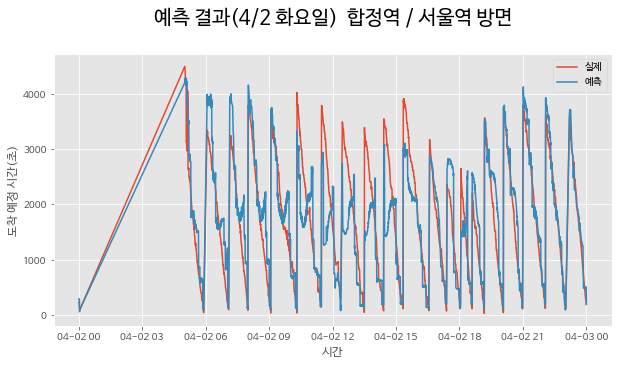

In [70]:
df1 = df_test_x[(df_test_x['bstopId_rabel']==0) & (df_test_x['month'] == 4) & (df_test_x['day'] == 2)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId_rabel']==0) & (df['month'] == 4) & (df['day'] == 2)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# 스케일링된 값을 기존값(초) 변환
result_df = result_df * (5863-18) + 18

# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(4/2 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

In [71]:
result_df

,ARRIVALESTIMATETIME,lstm
ThisDT,,
2022-04-02 00:01:03,242.00000,293.60614
2022-04-02 00:01:31,242.00000,297.20029
2022-04-02 00:02:00,134.00000,274.76349
2022-04-02 00:02:28,107.00000,63.17701
2022-04-02 00:02:57,105.00000,99.27762
...,...,...
2022-04-02 23:57:35,309.00000,502.03088
2022-04-02 23:58:32,282.00000,505.67932
2022-04-02 23:59:01,282.00000,475.11496


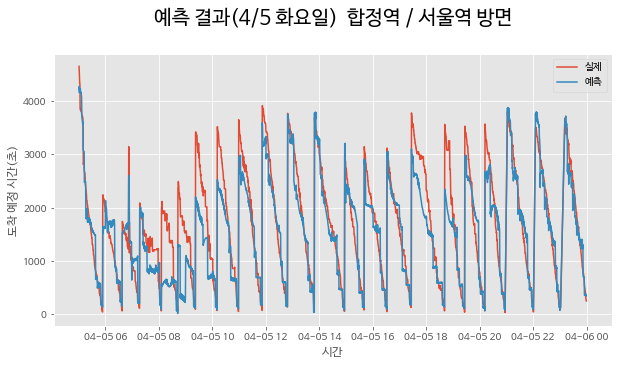

In [76]:
df1 = df_test_x[(df_test_x['bstopId_rabel']==0) & (df_test_x['month'] == 4) & (df_test_x['day'] == 5)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId_rabel']==0) & (df['month'] == 4) & (df['day'] == 5)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# 스케일링된 값을 기존값(초) 변환
result_df = result_df * (5863-18) + 18

# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(4/5 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

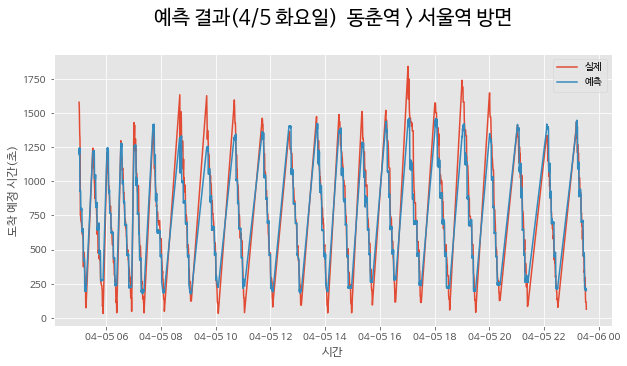

In [75]:
df1 = df_test_x[(df_test_x['bstopId_rabel']==3) & (df_test_x['month'] == 4) & (df_test_x['day'] == 5)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId_rabel']==3) & (df['month'] == 4) & (df['day'] == 5)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# 스케일링된 값을 기존값(초) 변환
result_df = result_df * (5863-18) + 18

# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(4/5 화요일)  동춘역 > 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

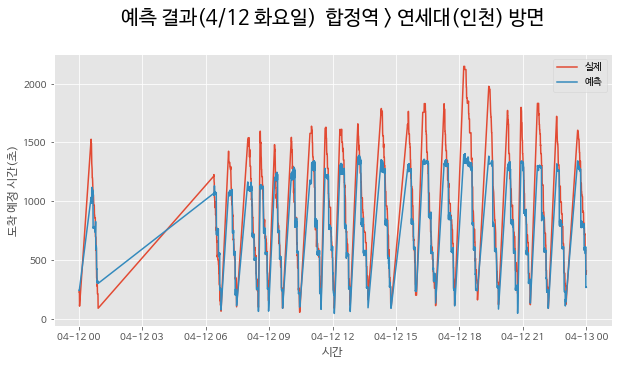

In [80]:
df1 = df_test_x[(df_test_x['bstopId_rabel']==2) & (df_test_x['month'] == 4) & (df_test_x['day'] == 12)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId_rabel']==2) & (df['month'] == 4) & (df['day'] == 12)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# 스케일링된 값을 기존값(초) 변환
result_df = result_df * (5863-18) + 18

# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(4/12 화요일)  합정역 > 연세대(인천) 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)